# Training
This notebook contains the code used to train the image classification network that powers and is at the heart of Chrysaora. Some notes and explanations are included throughout.

In [169]:
import os
import importlib
import numpy as np
import board
import engine
#importlib.reload(board)

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms.functional as TF

The following cell defines the dataset class. Best results were achieved by only training on board states appearing halfway through the game or later, hence the dataset class handles this by finding the midpoint of the game and returning board states after that point. White wins are classified as 2, black as 1 and draws as 0. This is largely due to a mixup on my part when swapping between networks. I intended draws to be 1, and black wins to be 0, but since this architecture remains my most successful to date I am hesitant to change it. 

Transforming the board to uint 8 and changing empty squares to 128 make the board more closely resemble an actual image, and thus increase the accuracy of the network slightly.

In [42]:
class PGNDataset(Dataset):
    def __init__(self, name, loc, transform=None):
        self.name = name # name of the PGN
        self.transform = transform
        
        self.board = board.load_pgn(name, loc)
        self.board.game_states.append(np.copy(self.board.current_state))
        
        self.start = int(len(self.board.move_list) / 2)

    def __len__(self):
        # Ply 17 (move 9) is when I'll consider, in general, that the opening book is complete.
        
        return len(self.board.move_list[self.start:])

    def __getitem__(self, index):
        
        b = self.board.game_states[index+self.start]
        c = b.astype("uint8")
        c = np.where(c == 0, 128, c)
        c = c.reshape(8,8,1)
        
        r = self.board.headers["Result"]
        
        if r == "1-0":
            #label = index / len(self.board.move_list[17:-30])
            label = 2
        elif r == "0-1":
            #label = -index / len(self.board.move_list[17:-30])
            label = 1
        else:
            label = 0
        
        if self.transform:
            c = self.transform(c)

        return (c, label)

In [151]:
def train(loader, net, crit, opt):
    net.train()
    running_loss = 0.0
    for i, batch in enumerate(loader, 0):
        
        # Get the input with their true labels
        inputs, labels = batch
        
        inputs = inputs.float()
        labels = labels #.float()
        
        # If we have a GPU this shifts labels and inputs onto it.
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zeros the optimzer
        opt.zero_grad()

        # Get the predicted labels and find the loss by comparing
        outputs = net(inputs)
        #print(outputs.shape)
        outputs = outputs.view(-1, 3)
        loss = crit(outputs, labels)
        
        # Propagate the loss backwards
        loss.backward()
        opt.step()
        
        #test = np.concatenate((outputs.detach().numpy().reshape(-1, 1), labels.numpy().reshape(-1, 1)), axis=1)
        #print(test)

        # Prints every div batches (Batch size currently 50, so every 50*div patches)
        running_loss += loss.item()
        div = 200
        if i % div == div - 1:
            #print(running_loss)
            print('[%d, %5d] Avg. loss: %.3f' % (epoch + 1, i + 1, running_loss / div))
            loss_history.append(running_loss / div)
            running_loss = 0.0

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cpu


In [153]:
%%time
normalize = transforms.Normalize(mean=[0.485], std=[0.229])
# Transformation object, converts to a tensor then normalizes.
trans = transforms.Compose([transforms.ToTensor(), normalize])

loc = os.path.join("network", *["train"])
games = os.listdir(loc)

# Macs still dumb.
if ".DS_Store" in games:
    games.remove(".DS_Store")

d = []

i = 0
for g in games:
    try:
        d.append(PGNDataset(g, loc, transform=trans))
        i += 1
    except:
        print(g)
        print(i)
        raise ValueError("You tried to make an illegal move!")
print(i)
data = ConcatDataset(d)
print(len(data))


1500
100594
CPU times: user 21min 47s, sys: 5.51 s, total: 21min 52s
Wall time: 21min 55s


In [154]:
trainloader = DataLoader(data, batch_size=25, shuffle=True, num_workers=4)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

Since the network architecture is contained within engine.py, we need to reload engine.py when we declare the Network, in case we've made changes. This updates those changes into the notebook.

In [162]:
importlib.reload(engine)
name = 'SkipNet.pt'
net = engine.SkipNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.02, momentum=0.90)

In [163]:
#%%time
num_epochs = 5
loss_history = []
for epoch in range(0, num_epochs):
    train(trainloader, net, criterion, optimizer)

print('Finished Training')

[1,   200] Avg. loss: 1.033
[1,   400] Avg. loss: 0.968
[1,   600] Avg. loss: 0.917
[1,   800] Avg. loss: 0.898
[1,  1000] Avg. loss: 0.878
[1,  1200] Avg. loss: 0.853
[1,  1400] Avg. loss: 0.845
[1,  1600] Avg. loss: 0.804
[1,  1800] Avg. loss: 0.780
[1,  2000] Avg. loss: 0.774
[1,  2200] Avg. loss: 0.772
[1,  2400] Avg. loss: 0.750
[1,  2600] Avg. loss: 0.726
[1,  2800] Avg. loss: 0.722
[1,  3000] Avg. loss: 0.724
[1,  3200] Avg. loss: 0.719
[1,  3400] Avg. loss: 0.695
[1,  3600] Avg. loss: 0.677
[1,  3800] Avg. loss: 0.674
[1,  4000] Avg. loss: 0.680
[2,   200] Avg. loss: 0.625
[2,   400] Avg. loss: 0.627
[2,   600] Avg. loss: 0.626
[2,   800] Avg. loss: 0.620
[2,  1000] Avg. loss: 0.607
[2,  1200] Avg. loss: 0.619
[2,  1400] Avg. loss: 0.596
[2,  1600] Avg. loss: 0.596
[2,  1800] Avg. loss: 0.581
[2,  2000] Avg. loss: 0.595
[2,  2200] Avg. loss: 0.578
[2,  2400] Avg. loss: 0.558
[2,  2600] Avg. loss: 0.564
[2,  2800] Avg. loss: 0.563
[2,  3000] Avg. loss: 0.574
[2,  3200] Avg. loss

In [164]:
loc = os.path.join("network", *["val"])
games = os.listdir(loc)

# Macs still dumb.
if ".DS_Store" in games:
    games.remove(".DS_Store")

d = []

i = 0
for g in games:
    try:
        d.append(PGNDataset(g, loc, transform=trans))
        i += 1
    except:
        print(g)
        print(i)
        raise ValueError("You tried to make an illegal move!")

print(i)
data = ConcatDataset(d)
valloader = DataLoader(data, batch_size=50, shuffle=True, num_workers=4)
print(len(data))

750
51933


The following hidden cell contains validation code for a regression style network rather than a classification network. It was a brief experiment I may go back to.

In [198]:
#%%time
# The array of predictions.
preds = np.asarray([])
#trues = np.asarray([])

correct = 0
total = 0
 
for data in valloader:
    # The true labels and image data
    inputs, labels = data
    
    # If we have a GPU this shifts labels and inputs onto it.
    inputs = inputs.to(device)
    labels = labels.to(device).numpy()
        
    # Gets the predicted labels
    outputs = net(inputs).detach().numpy().reshape(-1)
    
        
    # Adds to the total the number of labels here (should be equal to batch size)
    total = total + labels.shape[0]
        
    # If the predicted label is the same as the true label increment correct by 1
    # This line checks all 50 patches in the batch at once.
    #correct += (predicted == labels).sum().item()
    
    #trues = np.concatenate((trues, labels.to('cpu').numpy()))    
    #preds = np.concatenate((preds, predicted.to('cpu').numpy()))
    
    diff = outputs - labels
    #labels = np.where(labels==0, 0.001, labels)
    percent_diff = diff / labels
    #percent_diff = np.where(percent_diff > 500, float("nan"), percent_diff)
    
    preds = np.concatenate((preds, percent_diff))
    
    print(np.concatenate((outputs.reshape(-1, 1), labels.reshape(-1, 1)), 1))
    
    #print(total)
    if total % 2000 == 0:
        print('Board: ' + str(total))

accuracy = np.nanmean(preds)
print('Total pixels analyzed: ' + str(total))
print('Average Percent Difference: '  + str(accuracy) + '%')

[[1.47053289 1.        ]
 [1.47294271 2.        ]
 [1.47391415 1.        ]
 [1.47475195 1.        ]
 [1.47292137 2.        ]
 [1.47223032 1.        ]
 [1.47137928 1.        ]
 [1.47523427 1.        ]
 [1.47228026 1.        ]
 [1.47976303 1.        ]
 [1.47299099 2.        ]
 [1.47927547 2.        ]
 [1.47463882 2.        ]
 [1.47297502 2.        ]
 [1.47253942 1.        ]
 [1.47439313 1.        ]
 [1.47725439 1.        ]
 [1.47311342 1.        ]
 [1.47622824 1.        ]
 [1.47421455 1.        ]
 [1.47694182 2.        ]
 [1.47461593 2.        ]
 [1.47652984 1.        ]
 [1.47479439 1.        ]
 [1.48099899 2.        ]
 [1.47645843 1.        ]
 [1.47100401 2.        ]
 [1.47337818 1.        ]
 [1.47784555 2.        ]
 [1.47294748 2.        ]
 [1.4715966  2.        ]
 [1.47305703 1.        ]
 [1.47669172 1.        ]
 [1.47184587 1.        ]
 [1.47464943 1.        ]
 [1.47618246 1.        ]
 [1.48063016 2.        ]
 [1.4749825  1.        ]
 [1.47380888 1.        ]
 [1.46880209 1.        ]


KeyboardInterrupt: 

In [165]:
%%time
# The array of predictions.
preds = np.asarray([])
trues = np.asarray([])

correct = 0
total = 0

net.eval()
for data in valloader:
    # The true labels and image data
    inputs, labels = data
    
    # If we have a GPU this shifts labels and inputs onto it.
    inputs = inputs.to(device)
    #print(inputs.shape)
    #labels = labels
    labels = labels.to(device)
        
    # Gets the predicted labels
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
        
    # Adds to the total the number of labels here (should be equal to batch size)
    total = total + labels.size(0)
        
    # If the predicted label is the same as the true label increment correct by 1
    # This line checks all 50 patches in the batch at once.
    correct += (predicted == labels).sum().item()
    
    trues = np.concatenate((trues, labels.to('cpu').numpy()))    
    preds = np.concatenate((preds, predicted.to('cpu').numpy()))
    
    if total % 2000 == 0:
        print("Board: " + str(total))

accuracy = correct / total * 100
print('Total boards analyzed: ' + str(total))
print('Accuracy: '  + str(accuracy) + '%')

Board: 2000
Board: 4000
Board: 6000
Board: 8000
Board: 10000
Board: 12000
Board: 14000
Board: 16000
Board: 18000
Board: 20000
Board: 22000
Board: 24000
Board: 26000
Board: 28000
Board: 30000
Board: 32000
Board: 34000
Board: 36000
Board: 38000
Board: 40000
Board: 42000
Board: 44000
Board: 46000
Board: 48000
Board: 50000
Total boards analyzed: 51933
Accuracy: 48.76860570350259%
CPU times: user 22.7 s, sys: 554 ms, total: 23.3 s
Wall time: 5.92 s


In [167]:
torch.save(net.state_dict(), name[:-3] + '-' + str(round(accuracy)) + '.pt')

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

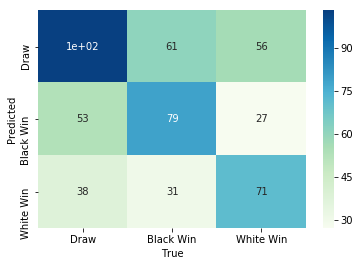

In [166]:
confusion = confusion_matrix(trues, preds)

classes = ["Draw", "Black Win", "White Win"]

confusion2 = confusion/1e2

sns.heatmap(confusion2.T, annot=True, cmap='GnBu', xticklabels=classes, yticklabels=classes)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()